# Red Neuronal Convolucional

Una red neuronal convolucional es un tipo de de red profunda en la que se comparten los pesos. Una de las redes colvulucionales más famosas es LeNet5 de Yan LeCun. En este notebook implementaremos la red neuronal convolucional Lenet5 con PyTorch.

<img src="archivos/lenet.png">



In [1]:
# importamos paquetes
# Cargamos paquetes necesarios

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import optim
from torchvision import datasets, transforms

#helper was developed by Udacity under MIT license
import helper

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:

print(device)

cuda:0


Para este ejemplo usaremos el conjunto de datos FashionMNIST

In [2]:
batch_size = 64

# Definimos una transformación de los datos
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Descargamos el conjunto de entrenamiento y cargamos mediante un dataLoader
trainset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

# Descargamos el conjunto de validación
testset = datasets.FashionMNIST('F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)

# Print out some stats about the training and test data
print('Train data, number of images: ', len(trainset))
print('Test data, number of images: ', len(testset))

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Train data, number of images:  60000
Test data, number of images:  10000


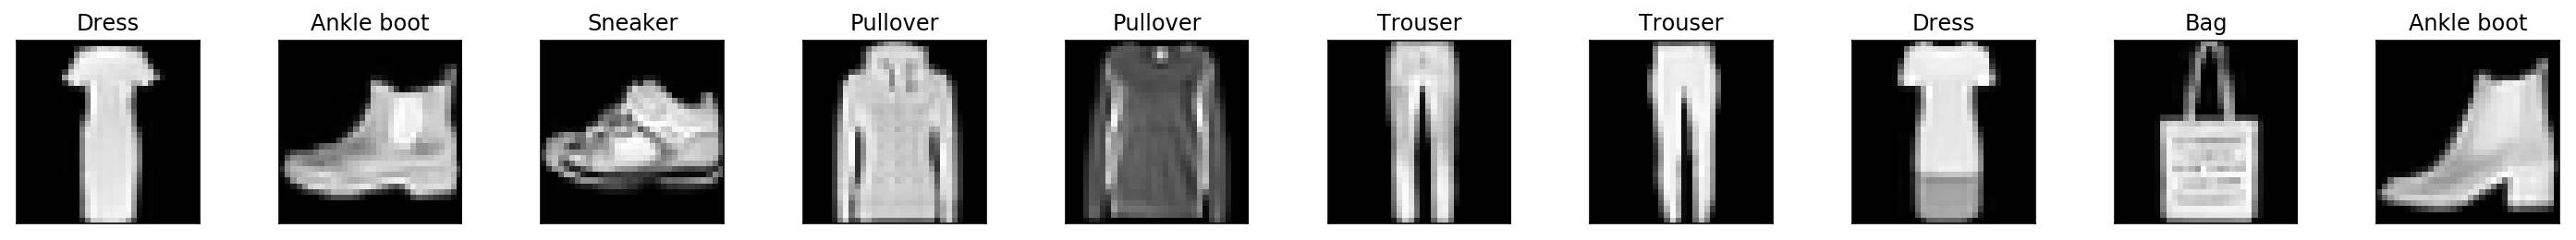

In [3]:
# obtain one batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()

display_size = 10

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx]])

## Creación de la RNC
Si estudiamos la arquitectura obsevaremos que esta compuesta por 2 capas convolucionales, despúes de cada convolución se realiza un max pooling. Al final de la red se agrega una red completamente conectada.


In [4]:
class LeNet5(nn.Module):
    def __init__(self, n_clases):
        '''
        Construimos la estructura de LeNet5
        
        '''
        super(LeNet5, self).__init__()
        
        # De acuerdo al artículo de LeCun La primera capa está compuesta por 6 kernels de 5x5
        self.conv1 = nn.Conv2d(1, 6, 5) # 1 canal de entrada 6 feature maps de salida, kernels de 5x5
        
        # Después tenemos una capa maxpooling
        # kernel_size=2, stride=2
        self.pool1 = nn.MaxPool2d(2, 2)
        
        # Agregamos otra capa convolucional con 16 kernels de 5 x 5
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Maxpooling
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Capas totalmente conectadas
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, n_clases)
    
    def forward(self, x):
        '''
        Definimos el pase frontal (forward pass)
        '''
        # Agregamos los ReLUs
        x = self.pool1(F.relu(self.conv1(x)))
        #print(x.size())
        x = self.pool2(F.relu(self.conv2(x)))

        # prep for linear layer by flattening the feature maps into feature vectors
        x = x.view(x.size(0), -1)
        # capas lineales
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)
    


## Entrenamiento y validación


In [5]:
# Create the network, define the criterion and optimizer
model = LeNet5(10)
model.to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# información de la red
model

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
# Implementamos una función de evaluación
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

        images.resize_(images.shape[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

### Implementación del entrenamiento y validación

In [9]:
from torch.autograd import Variable

#hiperparámetro

epochs = 5
steps = 0
running_loss = 0
print_every = 4*40


for e in range(epochs):
    # Cambiamos a modo entrenamiento
    #model.train()
       
    for images, labels in trainloader:
        steps += 1
        
        # Aplanar imágenes a un vector de 784 elementos
        # images.resize_(images.size()[0], 784)
        
        optimizer.zero_grad()
        
        # wrap them in a torch Variable
        images, labels = Variable(images), Variable(labels)    
        images, labels = images.to(device), labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)
        # Backpropagation
        loss.backward()
        # Optimización
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Cambiamos a modo de evaluación
            #model.eval()
            
            # Apagamos los gradientes, reduce memoria y cálculos
            #with torch.no_grad():
            #    test_loss, accuracy = validation(model, testloader, criterion)
                
            print("Epoch: {}/{}.. ".format(e+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every))
            #      "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
            #      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
            
            running_loss = 0
            
            # Make sure training is back on
            model.train()

Epoch: 1/5..  Training Loss: 0.308.. 
Epoch: 1/5..  Training Loss: 0.312.. 
Epoch: 1/5..  Training Loss: 0.309.. 
Epoch: 1/5..  Training Loss: 0.314.. 
Epoch: 1/5..  Training Loss: 0.307.. 
Epoch: 2/5..  Training Loss: 0.299.. 
Epoch: 2/5..  Training Loss: 0.293.. 
Epoch: 2/5..  Training Loss: 0.286.. 
Epoch: 2/5..  Training Loss: 0.293.. 
Epoch: 2/5..  Training Loss: 0.298.. 
Epoch: 2/5..  Training Loss: 0.282.. 
Epoch: 3/5..  Training Loss: 0.275.. 
Epoch: 3/5..  Training Loss: 0.262.. 
Epoch: 3/5..  Training Loss: 0.269.. 
Epoch: 3/5..  Training Loss: 0.286.. 
Epoch: 3/5..  Training Loss: 0.267.. 
Epoch: 3/5..  Training Loss: 0.275.. 
Epoch: 4/5..  Training Loss: 0.258.. 
Epoch: 4/5..  Training Loss: 0.252.. 
Epoch: 4/5..  Training Loss: 0.262.. 
Epoch: 4/5..  Training Loss: 0.255.. 
Epoch: 4/5..  Training Loss: 0.254.. 
Epoch: 4/5..  Training Loss: 0.261.. 
Epoch: 5/5..  Training Loss: 0.247.. 
Epoch: 5/5..  Training Loss: 0.234.. 
Epoch: 5/5..  Training Loss: 0.248.. 
Epoch: 5/5..

In [ ]:
# obtain one batch of test images
display_size = 10

dataiter = iter(testloader)
images, labels = dataiter.next()
# get predictions
#images = (Variable(images, volatile=True))
images = Variable(images)
images = images.to(device)
output = model(images)
output = output.cpu()
output_np = output.data.max(1, keepdim=True)[1].numpy()
preds = np.squeeze(output_np)
images = (images.cpu()).numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(display_size):
    ax = fig.add_subplot(2, display_size, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))